In [9]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [10]:
tau_truth = 5
low = tau_truth - 0.8
high = tau_truth + 0.8
step = 0.01
n1 = 5000 #number of time measurements in a particular experiment
n2=1000 #total number of experiments

In [11]:
# Generate 5000 exponentially distributed random variables with tau = true_tau.
def time_generator(tau, n, iloop):
    np.random.seed(iloop)
    time_measurements = np.random.exponential(scale=tau, size=n)
    return time_measurements

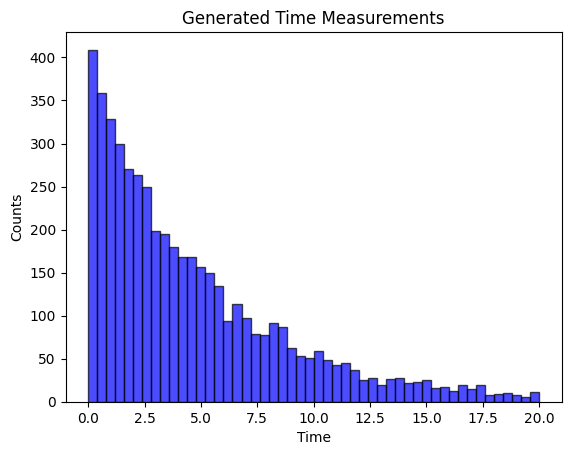

In [12]:
# Plot the time Measurements in a histogram.
def plot_time_measurements(time_measurements):
    plt.hist(time_measurements, bins=50, range=(0, 20), alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Time')
    plt.ylabel('Counts')
    plt.title('Generated Time Measurements')
    plt.show()
    
# Show the Plot
time_measurements = time_generator(tau_truth, n1, 42)
plot_time_measurements(time_measurements)

In [13]:
def binned_fit_time_measurements(bin_counts, bin_edges):
    def fcn(tau):
        n_total = np.sum(bin_counts)
        num_bins = len(bin_edges) - 1
        
        lnL = 0
        for i in range(num_bins):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i + 1]
            bin_mid = (bin_start + bin_end) / 2
            bin_width = bin_end - bin_start
            count = bin_counts[i]
            
            # Calculate -2lnL contribution for this bin
            expected_count = n_total / tau * np.exp(-bin_mid / tau) * bin_width
            if expected_count > 0:
                lnL += count * np.log(expected_count) - expected_count
        logl = -2 * lnL        
        return logl
    minuit = Minuit(fcn, tau=5)
    minuit.limits['tau'] = (0.1, 20)
    minuit.migrad()
    minuit.hesse()
    
    tau_expected = minuit.values['tau'] 
    error_tau_expected = minuit.errors['tau']
    
    #print(f"Expected tau: {tau_expected} ± {error_tau_expected}") 
    return tau_expected, 

# Calculate the expected tau from binned fit
bin_counts, bin_edges = np.histogram(time_measurements, bins=50, range=(0, 20))
tau_expected = binned_fit_time_measurements(bin_counts, bin_edges)


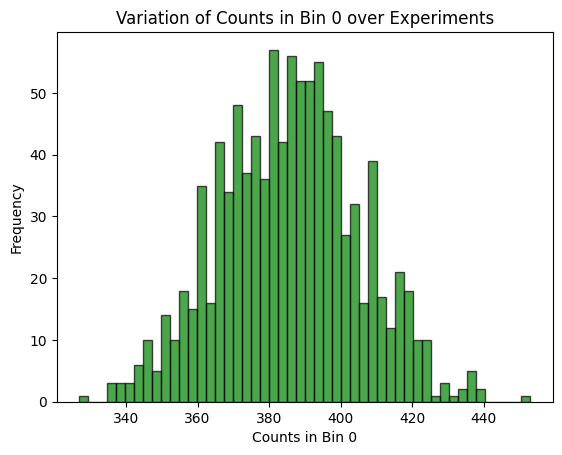

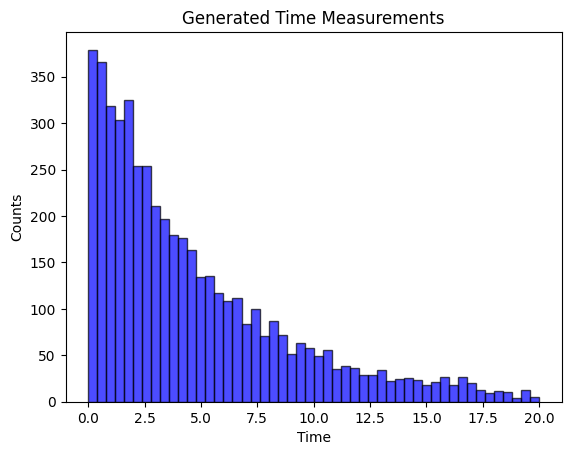

In [14]:
def check_distribution_variation(tau_true, num_experiments, num_events, bin_number):
    variation = []
    for i in range(num_experiments):
        time_measurements = time_generator(tau_true, num_events, i)
        bin_counts, bin_edges = np.histogram(time_measurements, bins=50, range=(0, 20))
        # Store the value of counts in the designated bin
        variation.append(bin_counts[bin_number])
    return variation

def plot_variation(variation, bin_number):
    plt.hist(variation, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel(f'Counts in Bin {bin_number}')
    plt.ylabel('Frequency')
    plt.title(f'Variation of Counts in Bin {bin_number} over Experiments')
    plt.show()
    
# Check distribution variation for a specific bin
variation = check_distribution_variation(tau_truth, n2, n1, 0)
plot_variation(variation, 0)
time_measurements = time_generator(tau_truth, n1, 0)
plot_time_measurements(time_measurements)
    

1000


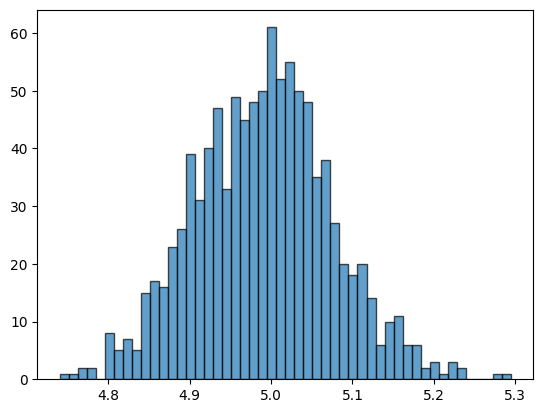

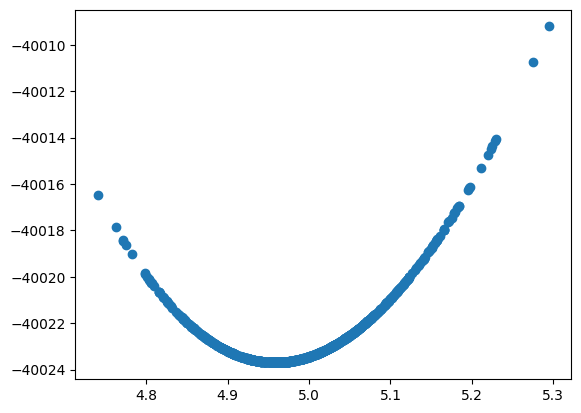

Minimum -LogLikelihood corresponds to the tau value: 


In [ ]:
def plot_tau_expected_distribution(tau_truth, num_experiments):
    tau_values = []
    
    for i in range(num_experiments):
        time_measurements = time_generator(tau_truth,n1,i)
        bin_count, bin_edges = np.histogram(time_measurements, bins=50, range=(0, 20))
        tau_expected = binned_fit_time_measurements(bin_count, bin_edges)[0]
        tau_values.append(tau_expected)
    print(len(tau_values))
    plt.hist(tau_values, bins=50, alpha=0.7, edgecolor='black')
    plt.show()
    likelihoods = []
    for tau in tau_values:
        time_measurements_tau = time_generator(tau,n1,i)
        bin_count, bin_edges = np.histogram(time_measurements_tau, bins=50, range=(0, 20))
        n_total = np.sum(bin_counts)
        num_bins = len(bin_edges) - 1
        
        lnL = 0
        for j in range(num_bins):
            bin_start = bin_edges[j]
            bin_end = bin_edges[j + 1]
            bin_mid = (bin_start + bin_end) / 2
            bin_width = bin_end - bin_start
            count = bin_counts[j]
            
            # Calculate -2lnL contribution for this bin
            expected_count = n_total / tau * np.exp(-bin_mid / tau) * bin_width
            if expected_count > 0:
                lnL += count * np.log(expected_count) - expected_count
            logl = -2 * lnL        
        likelihoods.append(logl)
        
    plt.scatter(tau_values, likelihoods)
    plt.show()
    tau_likelihood_dict = dict(zip(tau_values, likelihoods))
    min_log_l = np.min(likelihoods)
    tau_min = tau_values[np.argmin(likelihoods)]
    target = min_log_l +0.5
    
    print("Minimum -LogLikelihood corresponds to the tau value: ")


plot_tau_expected_distribution(5, 1000)